In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from sklearnex import patch_sklearn
patch_sklearn()
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from IPython.display import clear_output
import shap


import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Hourly distribution

In [4]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)

house_consumpion_columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_1', 
    'sub_metering_2',
    'sub_metering_3',
    'daily_energy_consumption_kwh'
]

df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


In [5]:
df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'ff',
       't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm',
       'ch', 'pres', 'rafper', 'per', 'ssfrai', 'perssfrai', 'rr1', 'rr3',
       'phenspe1', 'phenspe2', 'phenspe3', 'nnuage1', 'ctype1', 'hnuage1',
       'Nom', 'Latitude', 'Longitude', 'Altitude'],
      dtype='object')

## Train test split

In [6]:

def get_season(x):
    seasons = []
    month = x.month
    
    for m in month:
    # Define the seasons based on months
        if 3 <= m <= 5:
            season = "Spring"
        elif 6 <= m <= 8:
            season = "Summer"
        elif 9 <= m <= 11:
            season = "Autumn"
        else:
            season = "Winter"

        seasons.append(season)

    return seasons


In [7]:
def get_weekend_feature(df:pd.DataFrame):
    day_of_week = df.index.day_of_week
    is_weekend = (day_of_week == 5) | (day_of_week ==6)
    df['is_weekend'] = is_weekend.astype(float)

    return df

def get_season_feature(df : pd.DataFrame):
    seasons = get_season(df.index)
    df['season'] = seasons
    df = pd.concat(
        [
            df,
            pd.get_dummies(df['season'])
        ],
        axis = 1
    )

    return df



In [8]:
raw_train_df = df.loc[:'31-12-2009']
raw_test_df = df.loc['2010']

# ------------ train df -------------------------------

raw_train_df['daily_energy_consumption_kwh'] = raw_train_df['global_active_power']\
    .groupby(
        pd.Grouper(freq='1D')
    ).sum()/(60)

train_df = raw_train_df.dropna()

train_df = get_weekend_feature(train_df)
train_df = get_season_feature(train_df)


# ------------ test df ----------------------------------

raw_test_df['daily_energy_consumption_kwh'] = raw_test_df['global_active_power']\
    .groupby(
        pd.Grouper(freq='1D')
    ).sum()/(60)

test_df = raw_test_df.dropna()

test_df = get_weekend_feature(test_df)
test_df = get_season_feature(test_df)


### Selecting columns

In [9]:

corr = train_df.corr()

In [10]:
abs(corr.loc['daily_energy_consumption_kwh']).sort_values().dropna().tail(10)

sub_metering_3                  0.168541
vv                              0.179804
voltage                         0.217772
Winter                          0.218882
td                              0.284163
global_intensity                0.301547
t                               0.301961
Summer                          0.308917
global_active_power             0.315207
daily_energy_consumption_kwh    1.000000
Name: daily_energy_consumption_kwh, dtype: float64

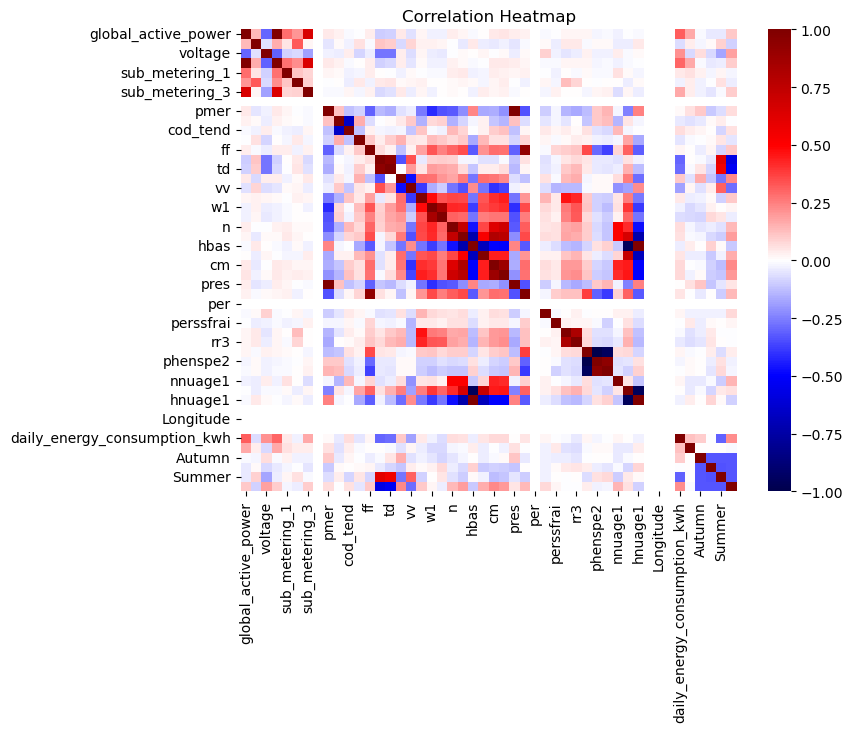

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Selecting features

In [12]:
selected_columns = corr['global_active_power'].abs() > 3e-2
selected_columns[house_consumpion_columns] = False
selected_columns = selected_columns[selected_columns].index

selected_columns

Index(['pmer', 'ff', 't', 'td', 'u', 'vv', 'n', 'cm', 'ch', 'pres',
       'is_weekend', 'Spring', 'Summer', 'Winter'],
      dtype='object')

## Optimization methods

### Choosing model- cross validation

In order to determine the optimal model for testing, we will train various models and select the one that demonstrates the highest average performance during the validation period.

In [13]:

def train(
    train_df : pd.DataFrame, 
    target: pd.Series,
    n_splits : int,
    models : List[BaseEstimator] = [
        SVR(kernel = 'rbf'), 
        LinearRegression(), 
        Lasso(), 
        DecisionTreeRegressor(max_depth = 4),
        RandomForestRegressor(n_estimators = 30, max_depth = 4), 
    ]
):
    """
    Train multiple regression models and evaluate their performance using cross-validation.

    Parameters:
    - train_df (pd.DataFrame): DataFrame containing the training features.
    - target (pd.Series): Series containing the target variable.
    - n_splits (int): Number of splits for cross-validation.
    - models (List[BaseEstimator], optional): List of regression models to train. Defaults to a list containing SVR, LinearRegression, Lasso, RandomForestRegressor, and MLPRegressor.

    Returns:
    - results (Dict[str, List[float]]): Dictionary containing the validation scores for each model.
    """
    
    results = {type(x).__name__ : [] for x in models}
    splitter = splitter = KFold(n_splits)

    for model in models:

        model_name : str = type(model).__name__
        
        clear_output()
        print(f"Running model selection for {model_name}")

        splits = splitter.split(train_df)

        for idx_train, idx_val in tqdm(splits, total = n_splits):
            X_train = train_df.iloc[idx_train]
            y_train = target.iloc[idx_train]

            X_val = train_df.iloc[idx_val]
            y_val = target.iloc[idx_val]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)

            validation_score = r2_score(y_val, y_pred)

            results[model_name].append(validation_score)

    return results

In [14]:
selected_columns = [
       'is_weekend', 'Autumn', 'Spring', 'Summer', 'Winter'
]

In [15]:

X_train = train_df[selected_columns]\
    .dropna()

y_train = train_df['daily_energy_consumption_kwh']

intersection_idx = y_train.index.intersection(X_train.index)

y_train = y_train.reindex(index = intersection_idx)
X_train = X_train.reindex(index = intersection_idx)

# ----------- test ---------------------

X_test = test_df[selected_columns].dropna()
y_test = test_df['daily_energy_consumption_kwh']
intersection_idx = y_test.index.intersection(X_test.index)

y_test = y_test.reindex(index = intersection_idx)
X_test = X_test.reindex(index = intersection_idx)

In [16]:

train_results = train(
    X_train,
    y_train,
    3
)

Running model selection for RandomForestRegressor


100%|██████████| 3/3 [00:00<00:00, 72.77it/s]


In [17]:
pd.DataFrame(train_results)

,SVR,LinearRegression,Lasso,DecisionTreeRegressor,RandomForestRegressor
0,0.110471,0.102172,0.023388,0.103073,0.103922
1,0.109612,0.109496,0.031570,0.113481,0.110726
2,0.159186,0.169992,0.050334,0.168785,0.172723


In [18]:
pd.DataFrame(train_results).mean()

SVR                      0.126423
LinearRegression         0.127220
Lasso                    0.035097
DecisionTreeRegressor    0.128446
RandomForestRegressor    0.129124
dtype: float64

As observed, weather features alone did not perform well during validation, as indicated by negative r2 scores. We will enhance them by incorporating features derived from previous target values.

## Experiment 2 - consumption features

In [89]:
frequencies = [1, 7]

X_train2 = X_train.copy()
y_train2 = y_train.copy()

X_test2 = X_test.copy()
y_test2 = y_test.copy()

for freq in frequencies:
    X_train2[f'avg_consumption_d-{freq}'] = y_train2.rolling(freq)\
        .mean()\
        .shift(1)
    
    # X_train2[f'diff_consumption_d-{freq}'] = y_train2.diff(freq)\
    #     .shift(1)
    
    X_test2[f'avg_consumption_d-{freq}'] = y_test2.rolling(freq)\
        .mean()\
        .shift(1)
    
    # X_test2[f'diff_consumption_d-{freq}'] = y_test2.diff(freq)\
    #     .shift(1)
    
X_train2 = X_train2.dropna()
y_train2 = y_train2.reindex(index = X_train2.index)

X_test2 = X_test2.dropna()
y_test2 = y_test2.reindex(index = X_test2.index)

# 

In [90]:
X_train2.corrwith(y_train2)

is_weekend             0.129212
Autumn                 0.099853
Spring                -0.006181
Summer                -0.310496
Winter                 0.220445
avg_consumption_d-1    0.510698
avg_consumption_d-7    0.365966
dtype: float64

In [91]:
model = LinearRegression().fit(X_train2, y_train2)

In [92]:
explainer = shap.LinearExplainer(model, X_train2)


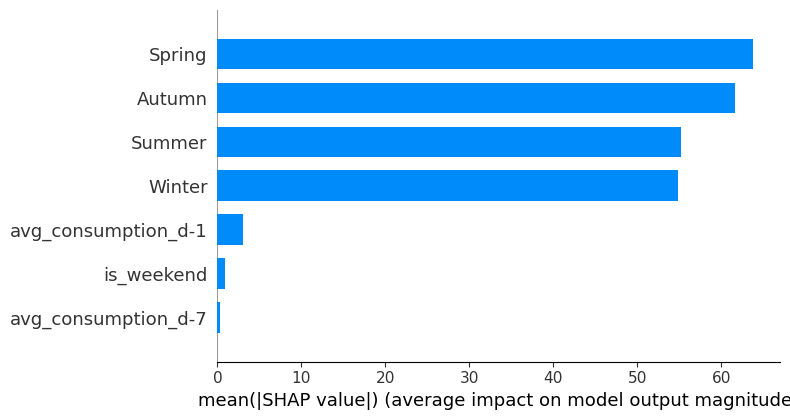

In [93]:
shap.summary_plot(explainer.shap_values(X_train2), X_train2, plot_type="bar")

In [94]:
X_train2

,is_weekend,Autumn,Spring,Summer,Winter,avg_consumption_d-1,avg_consumption_d-7
date,,,,,,,
2007-01-08,0.0,0,0,0,1,17.111067,26.924955
2007-01-09,0.0,0,0,0,1,18.069550,22.961071
2007-01-10,0.0,0,0,0,1,28.276433,22.785029
2007-01-11,0.0,0,0,0,1,27.834500,25.529090
2007-01-12,0.0,0,0,0,1,8.270267,20.545540
...,...,...,...,...,...,...,...
2009-12-27,1.0,0,0,0,1,35.973950,31.242590
2009-12-28,0.0,0,0,0,1,35.322750,33.582450
2009-12-29,0.0,0,0,0,1,34.649167,34.028455


In [95]:
results_experiment2 = train(
    X_train2,
    y_train2,
    10
    
)

Running model selection for RandomForestRegressor


100%|██████████| 10/10 [00:00<00:00, 68.87it/s]


In [96]:
pd.DataFrame(results_experiment2)

,SVR,LinearRegression,Lasso,DecisionTreeRegressor,RandomForestRegressor
0,0.103741,0.134490,0.094112,0.077044,0.163371
1,0.149735,0.173440,0.126101,-0.003961,0.114686
2,0.252281,0.268675,0.257091,0.218813,0.264957
3,0.197712,0.288595,0.264340,0.190558,0.234116
4,-0.042231,-0.025398,-0.021661,-0.045591,0.022396
5,0.360879,0.475364,0.424843,0.477090,0.450222
6,0.156492,0.239863,0.199757,0.118931,0.152018
7,0.042331,0.091691,0.049195,0.012513,0.117740
8,0.187564,0.218447,0.155895,0.107326,0.022047
9,0.062417,0.145291,0.064172,-0.038534,0.027932


In [97]:
pd.DataFrame(results_experiment2).mean()

SVR                      0.147092
LinearRegression         0.201046
Lasso                    0.161385
DecisionTreeRegressor    0.111419
RandomForestRegressor    0.156949
dtype: float64

In [98]:
model = LinearRegression()
model.fit(X_train2, y_train2)

LinearRegression()

In [99]:
y_pred = model.predict(X_test2)

In [100]:
r2_score(y_test2, y_pred)

0.16902835289136564

## LSTM

In [126]:
X_train3 = X_train2.loc[:'2008']
y_train3 = y_train2.loc[:'2008']


In [127]:
X_val3 = X_train2.loc['2009':]
y_val3 = y_train2.loc['2009':]

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from torcheval.metrics import R2Score
metric = R2Score()

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare the data
# Assuming X is a DataFrame and y is a Series
X_tensor = torch.tensor(X_train3.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train3.values, dtype=torch.float32).view(-1, 1)

X_tensor_val = torch.tensor(X_train3.values, dtype=torch.float32)
y_tensor_val = torch.tensor(y_train3.values, dtype=torch.float32).view(-1, 1)

# Define hyperparameters
input_size = X_train2.shape[1]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1  # Assuming y is a single output
batch_size = 5
num_epochs = 30
learning_rate = 0.001

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_tensor_val, y_tensor_val)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    predictions = torch.Tensor([])
    y_true = torch.Tensor([])
    for batch_X, batch_y in data_loader:
        # Forward pass
        outputs = model(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for X, y in val_data_loader:
        y_pred = model(X.unsqueeze(1))
        predictions = torch.concat([y_pred, predictions])
        y_true = torch.concat([y_true, y])

    metric.update(predictions, y_true)
    r2 = metric.compute()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], R2: {r2.item():.4f}')

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:00<00:21,  1.35it/s]

Epoch [1/30], R2: -2.1922


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

Epoch [2/30], R2: -1.5083


 10%|█         | 3/30 [00:02<00:22,  1.20it/s]

Epoch [3/30], R2: -1.1058


 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

Epoch [4/30], R2: -0.8799


 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

Epoch [5/30], R2: -0.7391


 20%|██        | 6/30 [00:04<00:18,  1.29it/s]

Epoch [6/30], R2: -0.6506


 23%|██▎       | 7/30 [00:05<00:17,  1.33it/s]

Epoch [7/30], R2: -0.5845


 27%|██▋       | 8/30 [00:06<00:16,  1.33it/s]

Epoch [8/30], R2: -0.5360


 30%|███       | 9/30 [00:06<00:16,  1.30it/s]

Epoch [9/30], R2: -0.5000


 33%|███▎      | 10/30 [00:07<00:15,  1.33it/s]

Epoch [10/30], R2: -0.4733


 37%|███▋      | 11/30 [00:08<00:14,  1.35it/s]

Epoch [11/30], R2: -0.4537


 40%|████      | 12/30 [00:09<00:14,  1.27it/s]

Epoch [12/30], R2: -0.4391


 43%|████▎     | 13/30 [00:10<00:14,  1.18it/s]

Epoch [13/30], R2: -0.4277


 47%|████▋     | 14/30 [00:11<00:15,  1.05it/s]

Epoch [14/30], R2: -0.4181


 50%|█████     | 15/30 [00:12<00:15,  1.01s/it]

Epoch [15/30], R2: -0.4098


 53%|█████▎    | 16/30 [00:13<00:14,  1.04s/it]

Epoch [16/30], R2: -0.4022


 57%|█████▋    | 17/30 [00:14<00:13,  1.05s/it]

Epoch [17/30], R2: -0.3953


 60%|██████    | 18/30 [00:15<00:12,  1.05s/it]

Epoch [18/30], R2: -0.3888


 63%|██████▎   | 19/30 [00:16<00:11,  1.03s/it]

Epoch [19/30], R2: -0.3828


 67%|██████▋   | 20/30 [00:17<00:10,  1.02s/it]

Epoch [20/30], R2: -0.3771


 70%|███████   | 21/30 [00:18<00:09,  1.01s/it]

Epoch [21/30], R2: -0.3717


 73%|███████▎  | 22/30 [00:19<00:08,  1.01s/it]

Epoch [22/30], R2: -0.3667


 77%|███████▋  | 23/30 [00:20<00:07,  1.00s/it]

Epoch [23/30], R2: -0.3621


 80%|████████  | 24/30 [00:21<00:06,  1.00s/it]

Epoch [24/30], R2: -0.3578


 83%|████████▎ | 25/30 [00:22<00:05,  1.05s/it]

Epoch [25/30], R2: -0.3537


 87%|████████▋ | 26/30 [00:23<00:04,  1.02s/it]

Epoch [26/30], R2: -0.3500


 90%|█████████ | 27/30 [00:24<00:03,  1.01s/it]

Epoch [27/30], R2: -0.3465


 93%|█████████▎| 28/30 [00:25<00:01,  1.01it/s]

Epoch [28/30], R2: -0.3433


 97%|█████████▋| 29/30 [00:26<00:00,  1.01it/s]

Epoch [29/30], R2: -0.3403


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]

Epoch [30/30], R2: -0.3375


tensor(-2.2001)

In [144]:
predictions

tensor([[10.5046],
        [10.4738],
        [10.5181],
        [10.5276],
        [10.5143],
        [10.5108],
        [10.5169],
        [10.5238],
        [10.5251],
        [10.5270],
        [10.5258],
        [10.5237],
        [10.5218],
        [10.5246],
        [10.5224],
        [10.5217],
        [10.5195],
        [10.5174],
        [10.5163],
        [10.5174],
        [10.5139],
        [10.5093],
        [10.4308],
        [10.5163],
        [10.5192],
        [10.5236],
        [10.5288],
        [10.5250],
        [10.5260],
        [10.5292],
        [10.5282],
        [10.5295],
        [10.5274],
        [10.5284],
        [10.5234],
        [10.5292],
        [10.5295],
        [10.5275],
        [10.5212],
        [10.5234],
        [10.5223],
        [10.5229],
        [10.5216],
        [10.5208],
        [10.5262],
        [10.5266],
        [10.5143],
        [10.5039],
        [10.5078],
        [10.5189],
        [10.5101],
        [10.4976],
        [10.

In [117]:
model(batch_X.unsqueeze(1))

1


tensor([[0.0481]], grad_fn=<AddmmBackward0>)

In [104]:
batch_y

tensor([[16.1029]])